In [1]:
from utils import *
%matplotlib inline

# Train the neural network

<br>
<center><img src="support/robot.gif" width=600></center>

In this section, we will discuss how to train the previously defined network with data. We first import the libraries. The new ones are `mxnet.init` for more weight initialization methods, the `datasets` and `transforms` to load and transform computer vision datasets, `matplotlib` for drawing, and `time` for benchmarking.

In [2]:
from mxnet import nd, gluon, init, autograd

from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms

import matplotlib.pyplot as plt
from time import time

## Get data

### Training Dataset: FashionMNIST

The handwritten digit MNIST dataset is one of the most commonly used datasets in deep learning. But it is too simple to get a 99% accuracy. Here we use a similar but slightly more complicated dataset called FashionMNIST. The goal is no longer to classify numbers, but clothing types instead.

The dataset can be automatically downloaded through Gluon's `data.vision.datasets` module. The following code downloads the training dataset and shows the first example.

In [3]:
mnist_train = datasets.FashionMNIST(train=True)
X, y = mnist_train[0]
print('X shape: %s dtype: %s' % (X.shape, X.dtype))
print("Number of images: %d" % len(mnist_train))

X shape: (28, 28, 1) dtype: <class 'numpy.uint8'>
Number of images: 60000


Each example in this dataset is a $28\times 28$ size grey image, which is presented as NDArray with the shape format of `(height, width, channel)`.  The label is a `numpy` scalar.

Next, we visualize the first six examples.

In [4]:
text_labels = [
    't-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'
]
def plot_images(X, y):
    # plot images
    _, figs = plt.subplots(1, X.shape[0], figsize=(15, 15))
    for f,x,yi in zip(figs, X,y):
        # 3D->2D by removing the last channel dim
        f.imshow(x.reshape((28,28)).asnumpy())
        ax = f.axes
        ax.set_title(text_labels[int(yi)])
        ax.title.set_fontsize(20)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

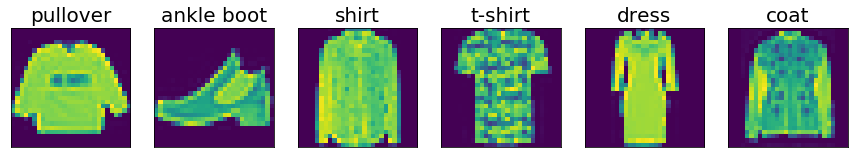

In [5]:
X, y = mnist_train[0:6]
plot_images(X, y)

<center><img src="support/fashionmnist.gif" width=700></center>

In order to feed data into a Gluon model, we need to convert the images to the `(channel, height, weight)` format with a floating point data type. It can be done by `transforms.ToTensor`. In addition, we normalize all pixel values with `transforms.Normalize` with the real mean 0.13 and variance 0.31. We chain these two transforms together and apply it to the first element of the data pair, namely the images.

`FashionMNIST` is a subclass of `gluon.data.Dataset`

Transform dataset:
- channel first, float32
- normalize



In [6]:
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.13, 0.31)])

mnist_train = mnist_train.transform_first(transformer)

`FashionMNIST` is a subclass of `gluon.data.Dataset`, which defines how to get the `i`-th example. In order to use it in training, we need to get a (randomized) batch of examples. It can be easily done by `gluon.data.DataLoader`. Here we use four works to process data in parallel, which is often necessary especially for complex data transforms.

### Data Loading

In [7]:
batch_size = 256

train_data = gluon.data.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)

The returned `train_data` is an iterator that yields batches of images and labels pairs.

In [8]:
for data, label in train_data:
    print(data.shape, label.shape)
    break

(256, 1, 28, 28) (256,)


Finally, we create a validation dataset and data loader.

### Validation Dataset

In [9]:
mnist_valid = gluon.data.vision.FashionMNIST(train=False)

valid_data = gluon.data.DataLoader(
    mnist_valid.transform_first(transformer),
    batch_size=batch_size, num_workers=4)

## Define the model

We reimplement the same LeNet introduced before. One difference here is that we changed the weight initialization method to `Xavier`, which is a popular choice for deep convolutional neural networks.

In [19]:
net = nn.Sequential()
with net.name_scope():
    net.add(
        nn.Conv2D(channels=6, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(120, activation="relu"),
        nn.Dense(84, activation="relu"),
        nn.Dense(10)
    )
net.initialize(init=init.Xavier())

Besides the neural network, we need to define the loss function and optimization method for training. We will use standard softmax cross entropy loss for classification problems. It first performs softmax on the output to obtain the predicted probability, and then compares the label with the cross entropy.

### Loss

In [11]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

<center><img src="support/cross_entropy.png" width=400></center>

The optimization method we pick is the standard stochastic gradient descent with constant learning rate of 0.1.

### Optimization

In [12]:
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': 0.1})

<center><img src="support/optimization.gif" width=400></center>

The `trainer` is created with all parameters (both weights and gradients) in `net`. Later on, we only need to call the `step` method to update its weights.

### Accuracy 

In [13]:
def acc(output, label):
    # output: (batch, num_output) float32 ndarray
    # label: (batch, ) int32 ndarray
    acc = (output.argmax(axis=1) == label.astype('float32'))
    return acc.mean().asscalar()

## Training loop

Now we can implement the complete training loop.

In [28]:
for epoch in range(10):
    train_loss, train_acc, valid_acc = 0., 0., 0.
    tic = time()
    for data, label in train_data:
        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        
        trainer.step(batch_size)
        
        train_loss += loss.mean().asscalar()
        train_acc += acc(output, label)

  
    print("Epoch[%d] Loss:%.3f Acc:%.3f|%.3f Perf: %.1f img/sec"%(
        epoch, train_loss/len(train_data),
        train_acc/len(train_data),
        valid_acc/len(valid_data), 
        len(mnist_train)/(time()-tic)))

UserWarning: Gradient of Parameter `sequential0_conv0_weight` on context cpu(0) has not been updated by backward since last `step`. This could mean a bug in your model that made it only use a subset of the Parameters (Blocks) for this iteration. If you are intentionally only using a subset, call step with ignore_stale_grad=True to suppress this warning and skip updating of Parameters with stale gradient

## Save the model

Finally, we save the trained parameters onto disk, so that we can use them later.


<center><img src="support/save.gif" width=600></center>

In [15]:
"Validation accuracy: %.2f"%(valid_acc/len(valid_data))

'Validation accuracy: 0.90'

In [16]:
net.save_params('net.params')